# Analysis notebook for DRIT paired image-to-image
Jesse Wilson (2021-2022) jesse.wilson@colostate.edu

In [1]:
# imports, dependencies, and notebook-wide dependencies
import sys
if '../src' not in sys.path:
    sys.path.append('../src')

from options import TestOptions, TrainOptions
from dataset import dataset_single, dataset_unpair
from model import DRIT
from random import randint

import torch
import matplotlib.pyplot as plt
import numpy as np

options_string ="""--dataroot /home/jessew/engrprojects/WilsonGroup/MRA_grant/aim1/data/20210617_ongoing/FOV300_pruned/ \
--name drit_20220204 \
--resume ../results/drit_20220204/01199.pth \
--gpu 0
--input_dim_a 1
--input_dim_b 1
--dis_spectral_norm
--lambda_L1_random_autoencoder=100
--contrastive_paired_zc
--lambda_paired_zc=10
--lambda_paired_zc_L1=100
--lambda_adversarial=0
--crop_size=256
--no_flip"""

# Load a dataset and saved model
Code here has been copied from ../src/train.py and ../src/test.py and modified to expose the objects we need.

In [2]:
def getDataset(opts):
    print('\n--- load dataset ---')
    if opts.a2b:
        dataset = dataset_single(opts, 'A', opts.input_dim_a)
    else:
        dataset = dataset_single(opts, 'B', opts.input_dim_b)
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=opts.nThreads)
    
    return dataset, loader

In [3]:
def getDataset(opts):
    print('\n--- load dataset ---')
    dataset = dataset_unpair(opts)
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=opts.nThreads)
    
    return dataset, loader

In [4]:
def getModel(opts):
    print('\n--- load model ---')
    model = DRIT(opts)
    model.setgpu(opts.gpu)
    model.resume(opts.resume, train=False)
    model.eval()
    
    return model

In [5]:
parser = TrainOptions()
opts = parser.parse(options_string.split())

opts.phase = "train"
dataset, loader = getDataset(opts)
opts.phase = "train"
model = getModel(opts)


--- load options ---
batch_size: 2
concat: 1
contrastive_margin: 1.0
contrastive_paired_zc: True
crop_size: 256
d_iter: 3
dataroot: /home/jessew/engrprojects/WilsonGroup/MRA_grant/aim1/data/20210617_ongoing/FOV300_pruned/
dis_norm: None
dis_paired: False
dis_paired_neg_examples: False
dis_scale: 3
dis_spectral_norm: True
display_dir: ../logs
display_freq: 1
gpu: 0
img_save_freq: 5
input_dim_a: 1
input_dim_b: 1
lambda_D_content: 1.0
lambda_L1_random_autoencoder: 100.0
lambda_adversarial: 0.0
lambda_paired_L1: 0.0
lambda_paired_L1_random: 0.0
lambda_paired_embedding: 0.0
lambda_paired_zc: 10.0
lambda_paired_zc_L1: 100.0
lambda_perceptual_random_autoencoder: 0.0
lr_policy: lambda
model_save_freq: 10
nThreads: 8
n_ep: 1200
n_ep_decay: 600
name: drit_20220204
no_display_img: False
no_flip: True
no_ms: False
paired_dataset: False
phase: train
resize_size: 256
result_dir: ../results
resume: ../results/drit_20220204/01199.pth
triplet_distance_norm: 2

--- load dataset ---


/usr/lib/python3/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


A: 4221, B: 4221 images

--- load model ---


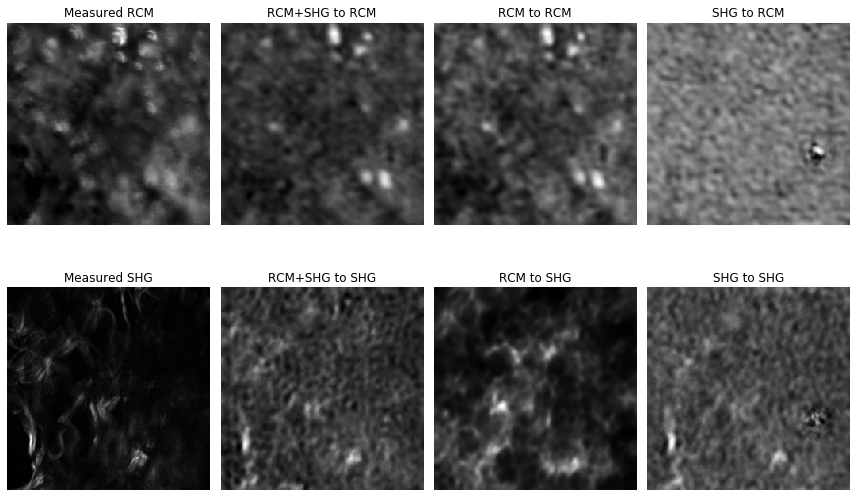

In [18]:
# select a random image
ind = randint(0,len(dataset.A)-1)
imgA = dataset.load_img(dataset.A[ind],opts.input_dim_a).unsqueeze(0)
imgB = dataset.load_img(dataset.B[ind],opts.input_dim_b).unsqueeze(0)
imgAB = torch.cat((imgA,imgB),dim=1)
imgA0 = torch.cat((imgA,1+2*torch.rand_like(imgB)),dim=1)
img0B = torch.cat((1+2*torch.rand_like(imgA),imgB),dim=1)

input_concatenated = torch.cat((imgAB,imgA0,img0B),dim=0)

# perform image translation
with torch.no_grad():
    z = model.enc_c.forward(input_concatenated.to(model.gpu))
    out = model.gen.forward(z)
    
out = out.cpu()

outABtoA = out[0:1,0:1,:,:]
outABtoB = out[0:1,1:2,:,:]
outAtoA  = out[1:2,0:1,:,:]
outAtoB  = out[1:2,1:2,:,:]
outBtoA  = out[2:3,0:1,:,:]
outBtoB  = out[2:3,1:2,:,:]


# plot the results
plt.figure(figsize=[12,8])

plt.subplot(241)
plt.imshow(np.squeeze(imgA.numpy()),cmap='gray')
plt.axis('off')
plt.title('Measured RCM')

plt.subplot(242)
plt.imshow(np.squeeze(outABtoA.numpy()),cmap='gray')
plt.title('RCM+SHG to RCM')
plt.axis('off')

plt.subplot(243)
plt.imshow(np.squeeze(outAtoA.numpy()),cmap='gray')
plt.title('RCM to RCM')
plt.axis('off')

plt.subplot(244)
plt.imshow(np.squeeze(outBtoA.numpy()),cmap='gray')
plt.title('SHG to RCM')
plt.axis('off')

plt.subplot(245)
plt.imshow(np.squeeze(imgB.numpy()),cmap='gray')
plt.axis('off')
plt.title('Measured SHG')

plt.subplot(246)
plt.imshow(np.squeeze(outABtoB.numpy()),cmap='gray')
plt.axis('off')
plt.title('RCM+SHG to SHG')

plt.subplot(247)
plt.imshow(np.squeeze(outAtoB.numpy()),cmap='gray')
plt.axis('off')
plt.title('RCM to SHG')

plt.subplot(248)
plt.imshow(np.squeeze(outBtoB.numpy()),cmap='gray')
plt.axis('off')
plt.title('SHG to SHG')

plt.tight_layout()
plt.show()

torch.Size([1, 2, 256, 256])


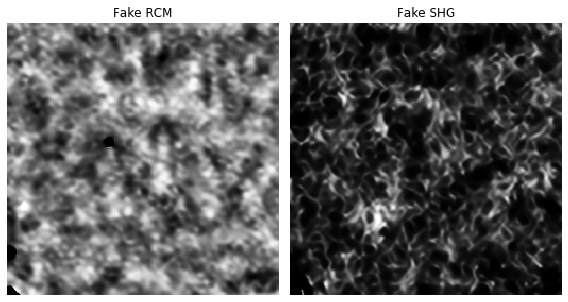

In [454]:
# produce a random image
ind = randint(0,len(dataset.A)-1)
imgA = dataset.load_img(dataset.A[ind],opts.input_dim_a).unsqueeze(0)
imgB = dataset.load_img(dataset.B[ind],opts.input_dim_b).unsqueeze(0)
imgAB = torch.cat((imgA,imgB),dim=1)

# encode
with torch.no_grad():
    z = model.enc_c.forward(imgAB.to(model.gpu))
    z = 2*torch.rand_like(z)-1
    
    out = model.gen.forward(z)
    
out = out.cpu()
print(out.shape)

outA = out[:,0:1,:,:]
outB = out[:,1:2,:,:]

plt.figure(figsize=[8,8])

plt.subplot(121)
plt.imshow(np.squeeze(outA.numpy()),cmap='gray')
plt.axis('off')
plt.title('Fake RCM')

plt.subplot(122)
plt.imshow(np.squeeze(outB.numpy()),cmap='gray')
plt.title('Fake SHG')
plt.axis('off')

plt.tight_layout()
plt.show()


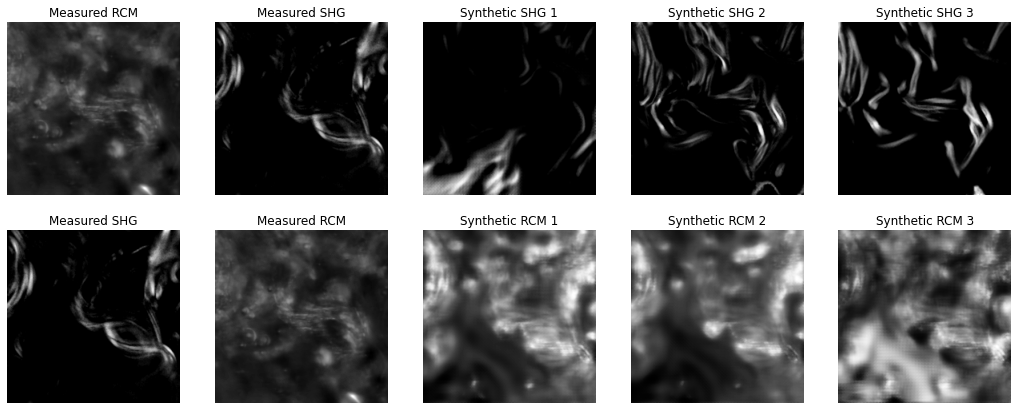

In [287]:
# select a random image
ind = randint(0,len(dataset.A)-1)
imgA = dataset.load_img(dataset.A[ind],opts.input_dim_a).unsqueeze(0)
imgB = dataset.load_img(dataset.B[ind],opts.input_dim_b).unsqueeze(0)

# perform image translation, make a few possibilities
with torch.no_grad():
    outA1 = model.test_forward(imgA.cuda())
    outA2 = model.test_forward(imgA.cuda())
    outA3 = model.test_forward(imgA.cuda())
    
    outB1 = model.test_forward(imgB.cuda(), a2b=False)
    outB2 = model.test_forward(imgB.cuda(), a2b=False)
    outB3 = model.test_forward(imgB.cuda(), a2b=False)

# plot the results
plt.figure(figsize=[18,7])

plt.subplot(2,5,1)
plt.imshow(np.squeeze(imgA.numpy()),cmap='gray')
plt.axis('off')
plt.title('Measured RCM')
plt.subplot(2,5,2)
plt.imshow(np.squeeze(imgB.numpy()),cmap='gray')
plt.title('Measured SHG')
plt.axis('off')
plt.subplot(2,5,3)
plt.imshow(np.squeeze(outA1.cpu().numpy()),cmap='gray')
plt.axis('off')
plt.title('Synthetic SHG 1')
plt.subplot(2,5,4)
plt.imshow(np.squeeze(outA2.cpu().numpy()),cmap='gray')
plt.axis('off')
plt.title('Synthetic SHG 2')
plt.subplot(2,5,5)
plt.imshow(np.squeeze(outA3.cpu().numpy()),cmap='gray')
plt.axis('off')
plt.title('Synthetic SHG 3')

plt.subplot(2,5,6)
plt.imshow(np.squeeze(imgB.numpy()),cmap='gray')
plt.axis('off')
plt.title('Measured SHG')
plt.subplot(2,5,7)
plt.imshow(np.squeeze(imgA.numpy()),cmap='gray')
plt.axis('off')
plt.title('Measured RCM')
plt.subplot(2,5,8)
plt.imshow(np.squeeze(outB1.cpu().numpy()),cmap='gray')
plt.axis('off')
plt.title('Synthetic RCM 1')
plt.subplot(2,5,9)
plt.imshow(np.squeeze(outB2.cpu().numpy()),cmap='gray')
plt.axis('off')
plt.title('Synthetic RCM 2')
plt.subplot(2,5,10)
plt.imshow(np.squeeze(outB3.cpu().numpy()),cmap='gray')
plt.axis('off')
plt.title('Synthetic RCM 3')

plt.show()

In [247]:
e = model.enc_c.forward(imgA.cuda(),imgB.cuda())
print(torch.mean(torch.abs(e[0]-e[1])))

a = model.enc_a.forward(imgA.cuda(), imgB.cuda())
print(torch.mean(torch.abs(a[0]-a[1])))

tensor(0.3642, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.8941, device='cuda:0', grad_fn=<MeanBackward0>)


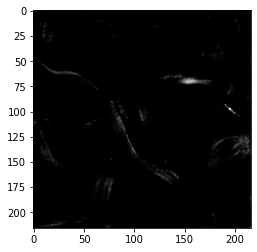

In [275]:
# try generating a panel of rcm2shg translations and averaging
n_trials = 100

with torch.no_grad():
    for i in range(n_trials):
        out = model.test_forward(imgA.cuda())
        
        if i == 0:
            outs = out
        else:
            outs = torch.cat((outs,out),0)
            
out = torch.median(outs,0).values

plt.imshow(np.squeeze(out.cpu().numpy()),cmap='gray')
plt.show()

In [257]:
out.values

tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -0.9999, -1.0000,  ..., -0.9980, -0.9918, -0.9965],
         [-0.9999, -1.0000, -0.9994,  ..., -0.9988, -0.9964, -0.9946],
         [-0.9997, -0.9993, -0.9987,  ..., -0.9807, -0.9838, -0.9397]]],
       device='cuda:0')